In [1]:
import sys
sys.path.append("/home/sxl/competition/yibao-cup")

In [2]:
from segmentation_package.model.unet import UNet
from segmentation_package.utils.utils import load_ckpt
from torch import optim
from torch.nn import BCEWithLogitsLoss
from segmentation_package.model.loss import match_loss

# load trained model

In [3]:
from torch.nn.parallel import DataParallel

In [4]:
from segmentation_package.utils.utils import set_devices

In [5]:
sys_device_ids = [0, 2]
TVT, TMO = set_devices(sys_device_ids)

In [6]:
model = UNet(2, base_channel=32)
model_w = DataParallel(model, )
# model.eval()
loss_fn = match_loss()
optimizer = optim.Adam(model.parameters(),
                     lr=1e-4,
                     weight_decay=1e-5)

# Bind them together just to save some codes in the following usage.
modules_optims = [model, optimizer]
TMO(modules_optims)
resume_ep, scores = load_ckpt(modules_optims, "../script/debug/exp/train/yibao-cup-data/pt_trainval_bc_32_lr_0.0001_exp_decay_at_151_total_5/run25/ckpt.pth")

/home/sxl/competition/yibao-cup/segmentation_package/utils/model_utils.py:26: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


Resume from ckpt ../script/debug/exp/train/yibao-cup-data/pt_trainval_bc_32_lr_0.0001_exp_decay_at_151_total_5/run25/ckpt.pth, 
epoch 5, 
scores 0


# load valid, test data

In [7]:
from segmentation_package.dataset import ValidationSet

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
from torch.autograd import Variable
import torch

In [10]:
im_dir = "/data/data_smile/img_mask/img/"
mask_dir = "/data/data_smile/img_mask/mask/"

total_sample_size = 40000
serial_nums = np.arange(total_sample_size)
train_serial_nums, valid_serial_nums = train_test_split(serial_nums, test_size=0.1, random_state=42)
test_serial_nums = np.arange(40000, 50000)

valid_set = ValidationSet(im_dir=im_dir,
                            mask_dir=mask_dir,
                            serial_nums=valid_serial_nums,
                            batch_size=32,
                            num_prefetch_threads=8)

test_set = ValidationSet(im_dir=im_dir,
                            mask_dir=mask_dir,
                            serial_nums=test_serial_nums,
                            batch_size=32,
                            num_prefetch_threads=8)

In [11]:
class classifier(object):
  """A function to be called in the val/test set, to segmentation.
  Args:
    TVT: A callable to transfer images to specific device.
  """
  def __init__(self, model, TVT):
    self.model = model
    self.TVT = TVT

  def __call__(self, ims):
    old_train_eval_model = self.model.training
    # Set eval mode.
    # Force all BN layers to use global mean and variance, also disable
    # dropout.
    self.model.eval()
    ims = Variable(self.TVT(torch.from_numpy(ims).float()))
    mask = self.model(ims)
    mask = mask.data.cpu().numpy()
    # Restore the model to its old train/eval mode.
    self.model.train(old_train_eval_model)
    return mask

In [12]:
def validate():
  if valid_set.classifier is None:
    valid_set.set_classifier(classifier(model_w, TVT))
  print('\n=========> Test on validation set <=========\n')
  max_iou, miou = valid_set.eval(verbose=True)
  print()
  return max_iou, miou

In [13]:
max_iou, miou = validate()


=========> Test on validation set <=========

Predicting images...
done:  False
Done, 2.90s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.19%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.62s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.58%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.63s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.41%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.63s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.39%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.63s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.48%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.62s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.49%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.64s
Computing scores...
Done, 0.26s
valid iou score:       

Done, 0.27s
valid iou score:              [maxiou: 97.35%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.64s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.35%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.61s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.61s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.62s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.63s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.62s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.63s
Computing scores...
Done, 

Done, 0.36s
valid iou score:              [maxiou: 97.33%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.70s
Computing scores...
Done, 0.35s
valid iou score:              [maxiou: 97.33%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.67s
Computing scores...
Done, 0.35s
valid iou score:              [maxiou: 97.33%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.66s
Computing scores...
Done, 0.35s
valid iou score:              [maxiou: 97.33%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.61s
Computing scores...
Done, 0.29s
valid iou score:              [maxiou: 97.33%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.28s
valid iou score:              [maxiou: 97.32%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.60s
Computing scores...
Done, 0.31s
valid iou score:              [maxiou: 97.33%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 

In [14]:
max_iou

0.9732941219368767

In [15]:
def test():
  if test_set.classifier is None:
    test_set.set_classifier(classifier(model_w, TVT))
  print('\n=========> Test on testing set <=========\n')
  max_iou, miou = test_set.eval(verbose=True)
  print()
  return max_iou, miou

In [16]:
max_iou_test, miou_test = test()


=========> Test on testing set <=========

Predicting images...
done:  False
Done, 0.96s
Computing scores...
Done, 0.29s
valid iou score:              [maxiou: 97.34%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 0.29s
valid iou score:              [maxiou: 97.53%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.30s
valid iou score:              [maxiou: 97.59%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.34s
valid iou score:              [maxiou: 97.43%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.61s
Computing scores...
Done, 0.31s
valid iou score:              [maxiou: 97.46%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.60s
Computing scores...
Done, 0.34s
valid iou score:              [maxiou: 97.47%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.28s
valid iou score:          

Done, 0.31s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.61s
Computing scores...
Done, 0.33s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.29s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.28s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.30s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.63s
Computing scores...
Done, 0.34s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.60s
Computing scores...
Done, 0.31s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 

Done, 0.28s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.36%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 

Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.37%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 

Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.28s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 

Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.59s
Computing scores...
Done, 0.27s
valid iou score:              [maxiou: 97.38%], [miou_0: 0.00%]
Predicting images...
done:  False
Done, 0.58s
Computing scores...
Done, 

In [17]:
max_iou_test

0.9738318978920191

In [18]:
valid_batch = valid_set.next_batch()

In [19]:
test_batch = test_set.next_batch()

In [20]:
valid_batch[2]

array(['img_16298.jpg', 'img_29591.jpg', 'img_6689.jpg', 'img_28505.jpg',
       'img_32823.jpg', 'img_36572.jpg', 'img_18948.jpg', 'img_12335.jpg',
       'img_26893.jpg', 'img_22241.jpg', 'img_35041.jpg', 'img_31067.jpg',
       'img_13787.jpg', 'img_5128.jpg', 'img_9125.jpg', 'img_19463.jpg',
       'img_16441.jpg', 'img_3510.jpg', 'img_26283.jpg', 'img_17407.jpg',
       'img_36216.jpg', 'img_30866.jpg', 'img_10919.jpg', 'img_34436.jpg',
       'img_12701.jpg', 'img_26173.jpg', 'img_35676.jpg', 'img_28283.jpg',
       'img_34089.jpg', 'img_21261.jpg', 'img_37266.jpg', 'img_33381.jpg'],
      dtype='<U13')

In [21]:
test_batch[2]

array(['img_40001.jpg', 'img_40000.jpg', 'img_40003.jpg', 'img_40007.jpg',
       'img_40006.jpg', 'img_40004.jpg', 'img_40005.jpg', 'img_40002.jpg',
       'img_40008.jpg', 'img_40014.jpg', 'img_40013.jpg', 'img_40011.jpg',
       'img_40012.jpg', 'img_40009.jpg', 'img_40010.jpg', 'img_40015.jpg',
       'img_40017.jpg', 'img_40016.jpg', 'img_40019.jpg', 'img_40018.jpg',
       'img_40022.jpg', 'img_40021.jpg', 'img_40020.jpg', 'img_40023.jpg',
       'img_40024.jpg', 'img_40027.jpg', 'img_40026.jpg', 'img_40025.jpg',
       'img_40029.jpg', 'img_40030.jpg', 'img_40028.jpg', 'img_40033.jpg'],
      dtype='<U13')

# visualization

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [39]:
from PIL import Image
import os.path as osp

In [50]:
def sigmoid(x):
  return 1. / (1 + np.exp(-x))

In [101]:
def visualize(im_names, masks, pred_masks, nrow=32):
    if nrow > len(im_names):
        nrow = len(im_names)
    for im_name, mask, pred_mask in zip(im_names, masks, pred_masks):
        pred_mask = sigmoid(pred_mask)
        im = np.asarray(Image.open(osp.join(im_dir, im_name)))
        
        fig, ax = plt.subplots(1, 6, figsize=(10, 10))
        
        ax[0].imshow(im)
        ax[0].axis("off")
        ax[1].imshow(mask.sum(axis=0),cmap="gray")
        ax[1].axis("off")
        pred_mask_0, pred_mask_1 = np.where(pred_mask[0]>0.5, 1, 0), np.where(pred_mask[1]>0.5, 1, 0)
        ax[2].imshow(pred_mask_0, cmap="gray")
        ax[2].axis("off")
        ax[3].imshow(pred_mask_1, cmap="gray")
        ax[3].axis("off")
        ax[4].imshow(np.expand_dims(pred_mask_0,axis=-1)*im)
        ax[4].axis("off")
        ax[5].imshow(np.expand_dims(pred_mask_1,axis=-1)*im)
        ax[5].axis("off")
        fig.tight_layout()

In [24]:
pred_valid, masks_valid, im_names_valid, mask_names_valid, done_valid = valid_set.predict_batch()

In [25]:
pred_test, masks_test, im_names_test, mask_names_test, done_test = test_set.predict_batch()

In [44]:
masks_valid.shape

(32, 2, 400, 400)

/home/sxl/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


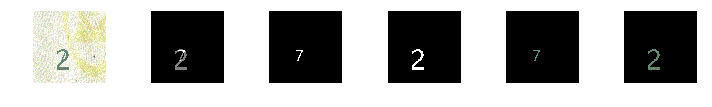

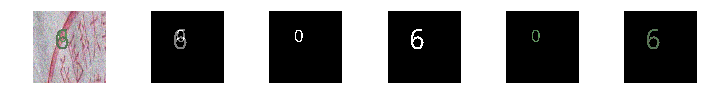

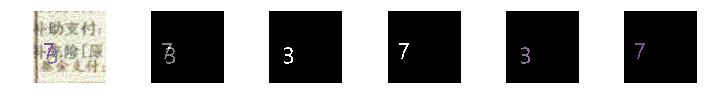

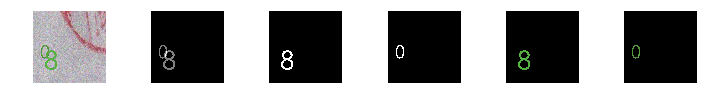

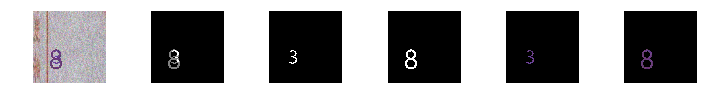

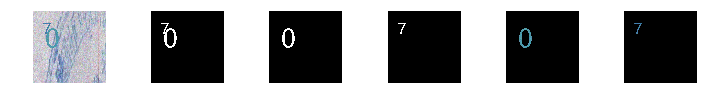

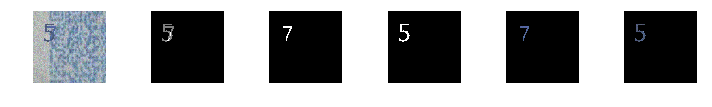

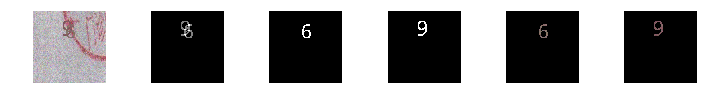

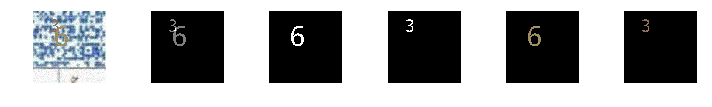

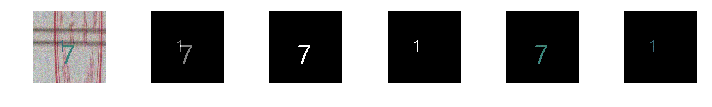

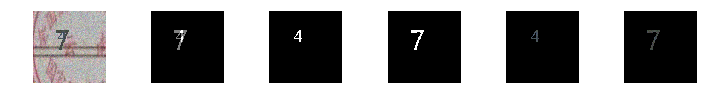

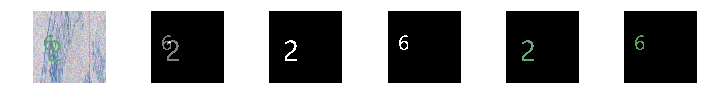

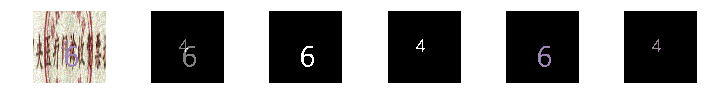

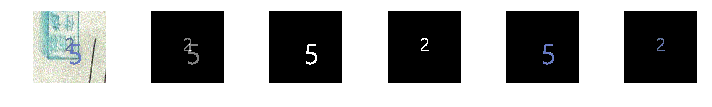

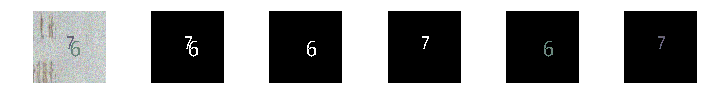

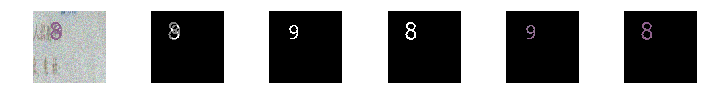

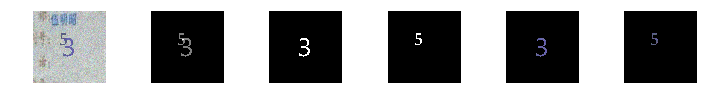

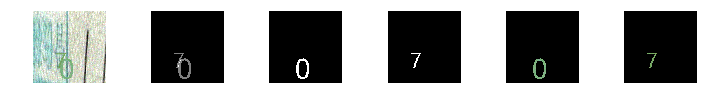

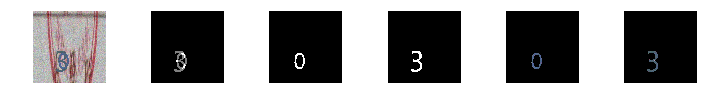

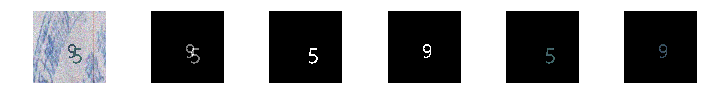

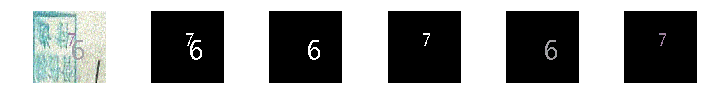

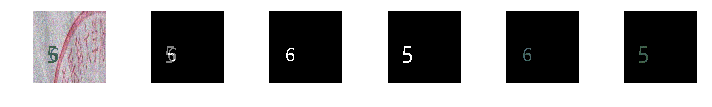

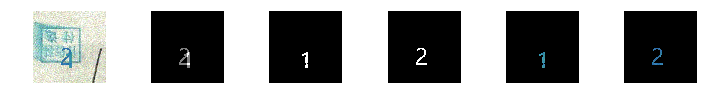

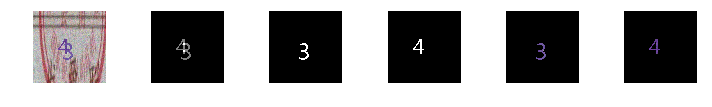

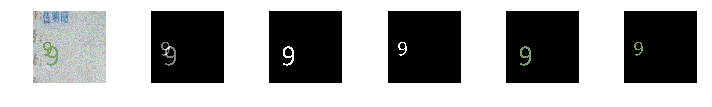

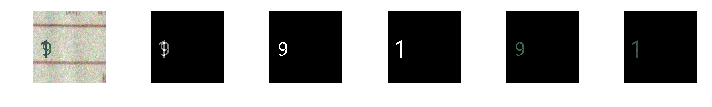

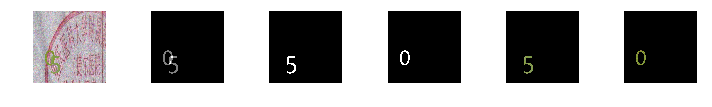

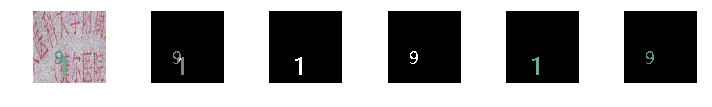

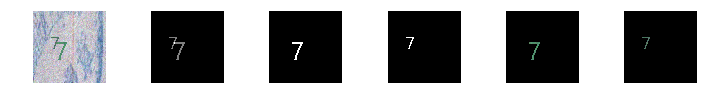

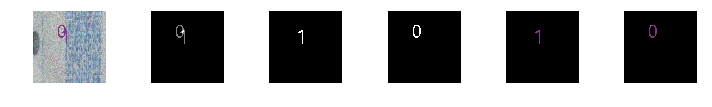

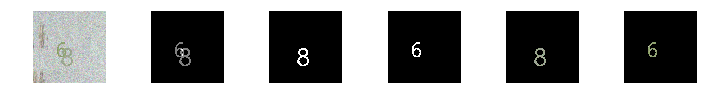

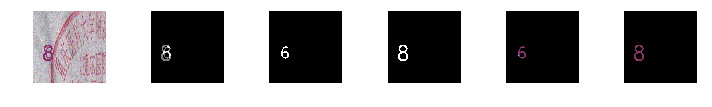

In [102]:
visualize(im_names=im_names_valid, masks=masks_valid, pred_masks=pred_valid)

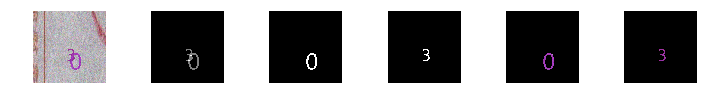

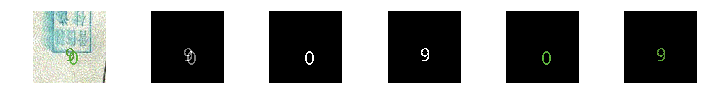

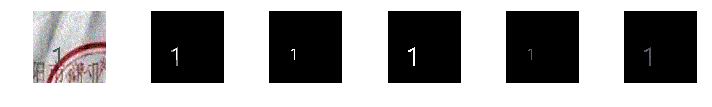

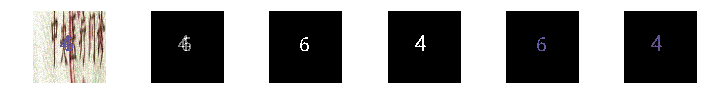

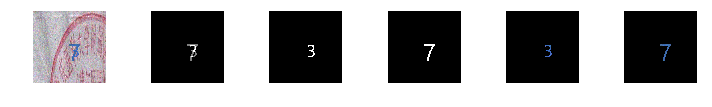

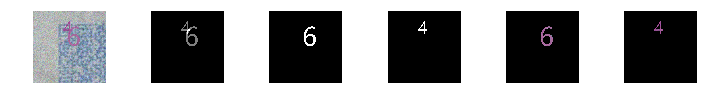

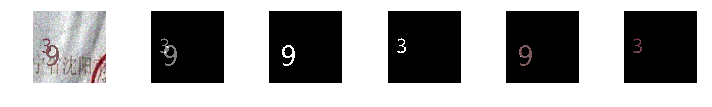

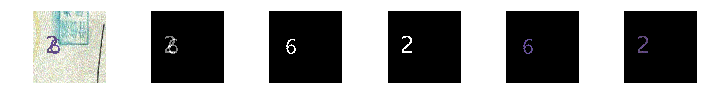

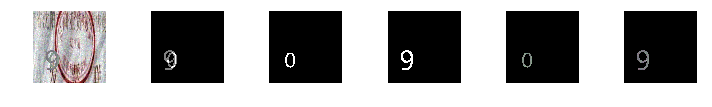

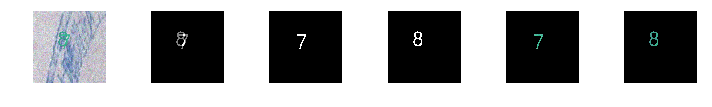

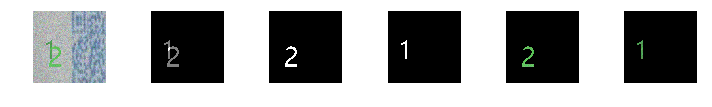

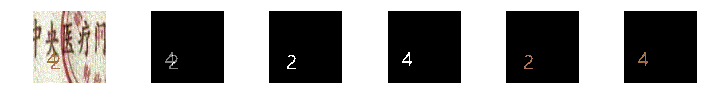

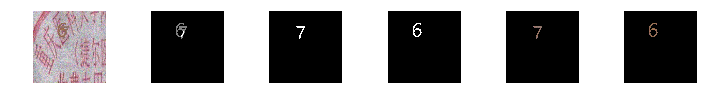

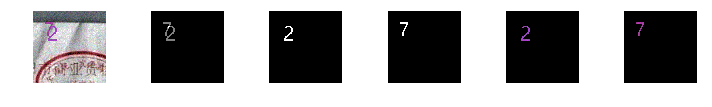

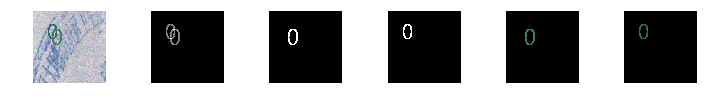

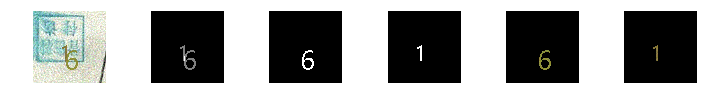

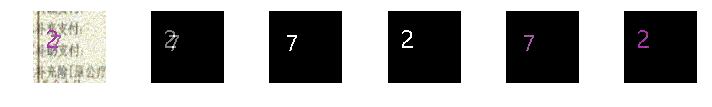

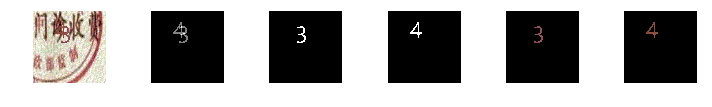

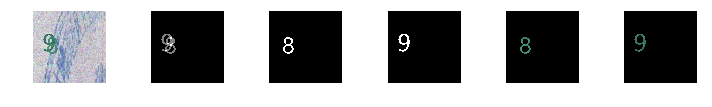

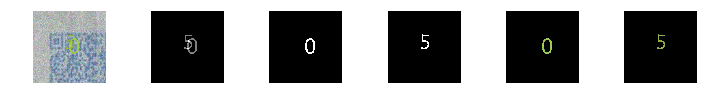

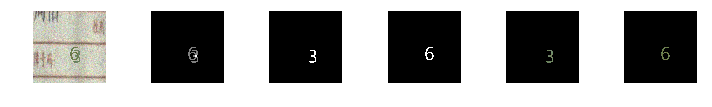

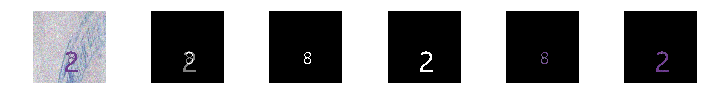

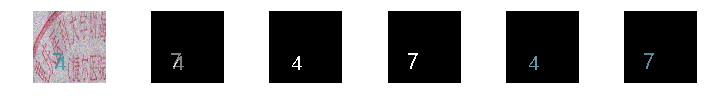

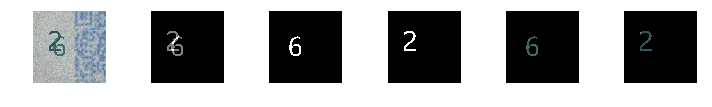

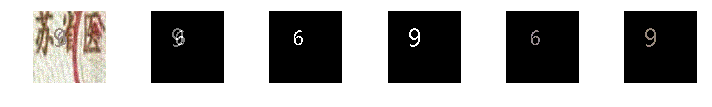

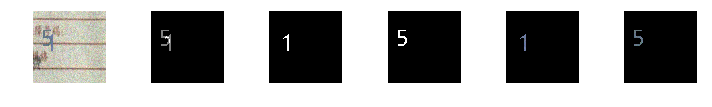

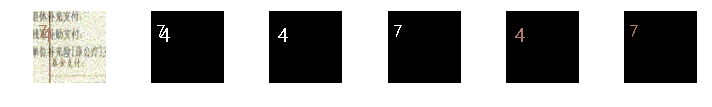

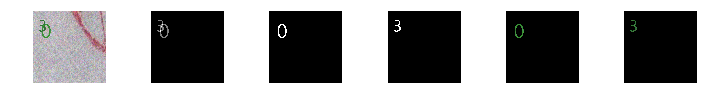

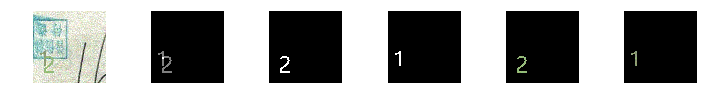

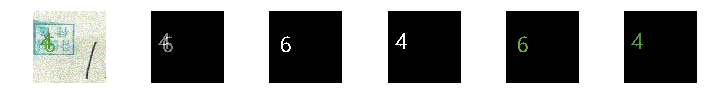

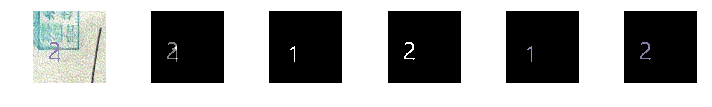

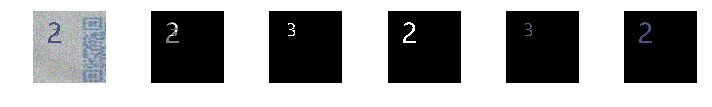

In [103]:
visualize(im_names=im_names_test, masks=masks_test, pred_masks=pred_test)